In [2]:
import numpy as np
from tqdm.notebook import tqdm
import torch
import matplotlib.pyplot as plt
from dataset import InpaintedDataset
import os
from torchvision.transforms import functional as F
from torchvision.models.segmentation import fcn_resnet50, FCN_ResNet50_Weights
from torch.utils.data import DataLoader
from sklearn.metrics import jaccard_score
import torch.nn as nn
from torchvision.ops.focal_loss import sigmoid_focal_loss
from  torch.utils.data import Subset
import matplotlib.pyplot as plt
import cv2
import matplotlib.patches as mpatches


In [3]:
data_dir = "../data/custom_inpainted/"
path_to_pretrained_weights = "checkpoints/baseline_final.pth"

# model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
weights = FCN_ResNet50_Weights.DEFAULT
model = fcn_resnet50(weights=weights)
# Modify the output layer
model.classifier[4] = nn.Conv2d(512, 1, kernel_size=(1, 1), stride=(1, 1))
model.aux_classifier[4] = nn.Conv2d(256, 1, kernel_size=(1, 1), stride=(1, 1))
model.load_state_dict(torch.load(path_to_pretrained_weights, map_location=device))
model = model.to(device)

# Define the loss function and optimizer
criterion = sigmoid_focal_loss

In [4]:
def collate_fn(examples):
    images, masks = zip(*examples)

    # Ensure images always have 3 channels
    images = [img if img.shape[0] == 3 else img.repeat((3, 1, 1)) for img in images]
    
    # Add a singleton dimension to represent the channel dimension in masks
    masks = [mask.unsqueeze(0) for mask in masks]
    
    # Make sure images are always 512x512 by cropping or padding
    images = [F.resize(img, [512, 512]) if max(img.shape[1:]) > 512 else F.pad(img, (0, 512-img.shape[2], 0, 512-img.shape[1])) for img in images]
    masks = [F.resize(mask, [512, 512]) if max(mask.shape[1:]) > 512 else F.pad(mask, (0, 512-mask.shape[2], 0, 512-mask.shape[1])) for mask in masks]

    # Stack images and masks into tensors
    images = torch.stack(images)
    masks = torch.stack(masks)

    return images, masks

def quantified_test(data):
    model.eval()
    running_loss = 0
    total_iou = 0
    with torch.no_grad():
        for batch in tqdm(data):
            inputs, labels = batch
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)["out"]
            loss = criterion(outputs, labels, reduction='mean')

            running_loss += loss.item()

            # Calculate IoU
            pred = (torch.sigmoid(outputs) > 0.5).int()
            labels = (torch.sigmoid(labels) > 0.5).int()
            total_iou += jaccard_score(labels.flatten().cpu().numpy(), pred.flatten().cpu().numpy())

    test_loss = running_loss / len(data)
    iou = total_iou / len(data)
    print('Test Loss: %.3f | Test IoU: %.3f' % (test_loss, iou))

def visualize_test(data, model, device):
    model.eval()
    with torch.no_grad():
        for batch in data:
            inputs, labels = batch
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)["out"]

            # Convert to binary masks
            pred_mask = (torch.sigmoid(outputs) > 0.5).int().squeeze().cpu().numpy()
            true_mask = labels.squeeze().cpu().numpy()  # No need to apply sigmoid and thresholding

            # Find contours for the masks
            pred_contours, _ = cv2.findContours(pred_mask.astype('uint8'), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
            true_contours, _ = cv2.findContours(true_mask.astype('uint8'), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

            # Create an image to draw on
            img = inputs.squeeze().cpu().numpy().transpose((1, 2, 0))
            img = ((img - img.min()) / (img.max() - img.min()) * 255).astype('uint8')  # Normalize to [0, 255] for visualization

            # Draw the predicted contours in red
            img = cv2.drawContours(img.copy(), pred_contours, -1, (255, 0, 0), thickness=2)

            # Draw the true contours in green
            img = cv2.drawContours(img.copy(), true_contours, -1, (0, 255, 0), thickness=2)

            # Create custom legend
            red_patch = mpatches.Patch(color='red', label='Prediction')
            green_patch = mpatches.Patch(color='green', label='Ground Truth')
            plt.legend(handles=[red_patch, green_patch])

            plt.imshow(img)
            plt.show()


In [5]:
test_dataset = InpaintedDataset(os.path.join(data_dir, 'test'))
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=2, collate_fn=collate_fn)
quantified_test(test_loader)

  0%|          | 0/186 [00:00<?, ?it/s]

Test Loss: 0.047 | Test IoU: 0.172


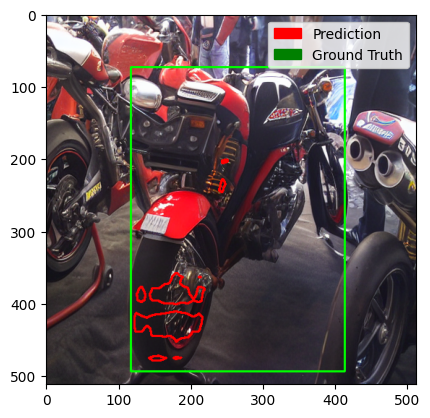

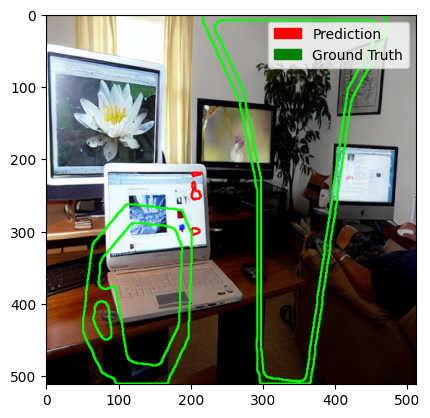

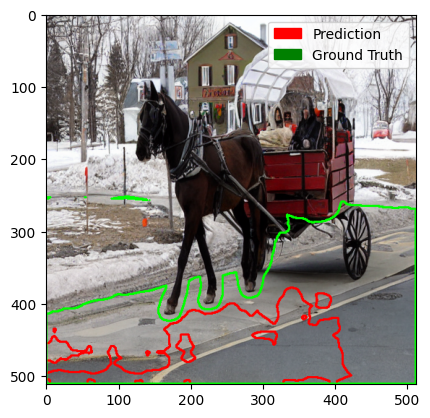

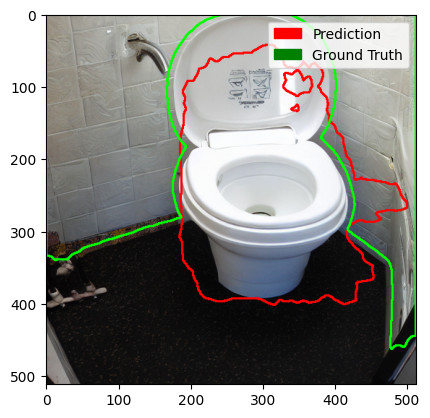

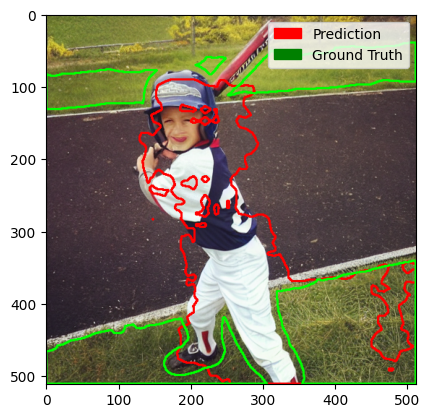

In [6]:
test_dataset = InpaintedDataset(os.path.join(data_dir, 'test'))
indecies = np.random.randint(0, len(test_dataset), 5)
test_dataset = Subset(test_dataset, indecies)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=1, collate_fn=collate_fn)
visualize_test(test_loader, model, device)